# LCPB 21-22 exercise 4: XGBoost

Alessandro Zanoli, Emerson Rodrigues Vero filho, Luca Giorgetti, Raffaele Gaudio

#### TASK 1

Consider the dataset generated for exercise 03 on convolutional neural networks (CNN), namely the samples of the stochastic time series with labels 0,1,2 depending on the eventual addition of another transient signal.

a) Compare the accuracy of a CNN with that of an XGBoost model trained with the features extracted by tsfresh from same data, in the limit of small datasets. For instance, try values of N=20, 50, 100, 150, 200, 250, 300, 400, 500. In all cases show also the standard deviation of the accuracy, obtained from several independent training and test procedures on different datasets.

b) For task a) we have seen during the lesson that XGBoost finds some features more relevant than others. Find the description of those features in the documentation and try to provide an explanation of why they are relevant for that problem.

c) OPTIONAL: with the features extracted by tsfresh, train a standard (non-convolutional) feed forward neural network (FFNN) and compare the performances with those of XGBoost. Than keep only the most relevant features from XGBoost and train another FFNN with this smaller set. Is the new FFNN working better than the one trained with all features?

#### TASK 2

For the labeling of simple two dimensional data (as the one generated during the lesson), try different parameters (gamma, lambda, n_estimators, ...), aiming to find the simplest yet effective XGBoost model that keeps a good accuracy.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from tsfresh import extract_features
from xgboost import XGBClassifier, plot_tree

plt.style.use('seaborn')
plt.rcParams['font.size'] = 14

%run plot.py

## Loading Data

In [23]:
#use the dataset generated in the last exercise (we have to use the same data as in exercise 3 because we will compare the performances of CNN and Xgboost)

str0 = 'ts_L200_Z12_A500_DX50_bias5_N10000.npy'
fnamex='DATA/x_'+str0
fnamey='DATA/y_'+str0

x=np.load(fnamex)
y=np.load(fnamey)

#rearranging the labels to be unidimensional
y_2=[] 
for i in range(len(y)):
    for j in range(3):
        if y[i][j]==1:
            y_2.append(j)

y=np.array(y_2)

N,L = len(x), len(x[0])

"""
we split the data after 

N_train= int(N*0.8)
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]
"""

'\nwe split the data after \n\nN_train= int(N*0.8)\nx_train,y_train = x[:N_train],y[:N_train]\nx_test,y_test = x[N_train:],y[N_train:]\n'

In [24]:
print(N,L)

10000 200


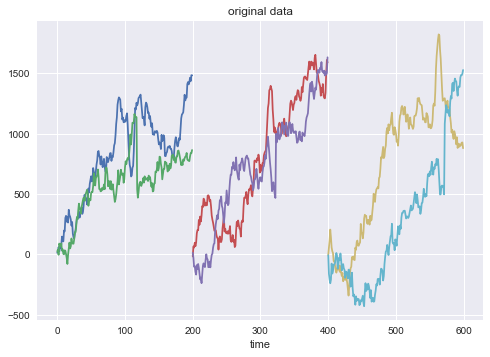

In [14]:
Show_data(x,L,"original data")

## TSFRESH: extract features

In [25]:
#per i blocchi a seguire dobbiamo aggiustare l'input (abbiamo una serie 2d)

def get_df(x):
    '''Build input dataframe for given data series
    Input:
    var = array of time series, (#samples,time,1)
    Return:
    df = dataframe ready for features extraction
    '''
    
    #N = #samples, t = timesteps
    N, t = x.shape[0], x.shape[1]
    #build id columns
    id_col = np.repeat(np.arange(N),t)
    #build time columns
    time_col = np.tile(np.arange(t),N)
    #build var columns
    x_col = x.flatten()
      
    #build dict for df
    x_dict = {'id':id_col,'time':time_col,'value':x_col}
        
    #return dataframe
    return pd.DataFrame(x_dict)

In [26]:
df=get_df(x)

ValueError: All arrays must be of the same length

In [ ]:
#extract features
x_features = extract_features(
                            df, #our dataframe
                            column_id='id', #sample id, from 0 to N
                            column_sort='time', #timestep, from 0 to t
                            column_kind=None, #we have only one feature
                            column_value='value', #value of input 
                            n_jobs=4) #number of cores

In [ ]:
#remove columns with NaN or inf
x_features.replace([np.inf, -np.inf], np.nan)
x_features = x_features.dropna(axis='columns')

In [ ]:
#look at clean x_features
x_features

### Split train/validation

In [ ]:
#split data into training and validation

perc_train=0.8
N_train = int(perc_train*N)
x_train = x_features[:N_train]
y_train = y[:N_train]
x_val = x_features[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  n_class=',n_class)

#rescale: in each feature, remove average and divide by std
if True:
    average = np.mean(x_train,axis=0)
    x_train -= average
    x_val -= average

    std = np.std(x_train,axis=0)
    x_train /= std
    x_val /= std

## XGBoost


In [ ]:
# reproducibility
np.random.seed(12345)

#define parameters for xgboost
params = {'max_depth':6,'min_child_weight':1,\
          'learning_rate':0.3,'use_label_encoder':False}

#build model with given params
model = XGBClassifier(**params)

#fit
model.fit(x_train.values,y_train)

In [ ]:
#plot tree

fig, AX = plt.subplots(3,1,figsize=(30, 10))
for i in range(3):
    ax=AX[i]
    plot_tree(model, num_trees=i, ax=ax)
    
fig.savefig("DATA/trees-time-ser.png", dpi=300, pad_inches=0.02)

In [ ]:
from sklearn.metrics import accuracy_score

#predict labels on training set
y_pred_train = model.predict(x_train)
#predict labels on validation set
y_pred_val = model.predict(x_val)

y_pred_val_soft = model.predict_proba(x_val)



#compute accuracies
acc_train = accuracy_score(y_train,y_pred_train) 
acc_val = accuracy_score(y_val,y_pred_val)

#print accuracies
print('Training accuracy:',acc_train)
print('Validation accuracy:',acc_val)